# Automatic differentiation

This example notebook shows how one can leverage `JAX`'s automatic differentiation capabilities to compute derivatives of functions, even if they involve solving the TOV equations as intermediate step. 

Have a look at the other example notebook to see in detail how to construct the EOS and solve the TOV equations for the metamodel and speed-of-sound parameterization.

**NOTE**: This example notebook requires additional dependencies for the Adam optimizer. 

In [1]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16}
plt.rcParams.update(params)
import matplotlib.cm as cm
import matplotlib.colors as colors

import jax
import jax.numpy as jnp

from jesterTOV.eos import Interpolate_EOS_model, construct_family
import jesterTOV.utils as utils

## EOS and TOV setup

First, we will define the EOS class used to construct the EOS quantities

In [2]:
e1,p1,d1 = np.loadtxt('eos_nl3.out',usecols=(0,1,2),unpack=True)
e2,p2,d2 = np.loadtxt('eos_SLY4.out',usecols=(0,1,2),unpack=True)
# Create an instance of the Interpolate_EOS_model
eos_interpolator = Interpolate_EOS_model()
# Call the interpolate_eos method with the loaded data
ns, ps, hs, es, dloge_dlogps = eos_interpolator.interpolate_eos(n=d2, p=p2, e=e2) #target nl3
#initial_eos
ns_i, ps_i, hs_i, es_i, dloge_dlogps_i = eos_interpolator.interpolate_eos(n=d1, p=p1, e=e1) #initial sly4

We'll make a lambda function to isolate the EOS input in the TOV solver, and fix the kwargs to user-specified values:

In [3]:
construct_family_lambda = lambda x: construct_family(x, ndat = 100, min_nsat = 1.0)

We first define an auxiliary function that helps us in constructing the EOS when given a dictionary of parameters. This will be an important component of the objective function that will have to be optimized later on. Note that `JAX` can differentiate functions that take dictionaries as argument, so we will use this approach to construct the EOS -- that allows us more control over the input and how it is parsed. 

In [4]:
def transform_func(params: dict[str, float]) -> dict[str, float]:
    """
    Auxiliary transformation function that takes in a dict of parameters for the metamodel and speed-of-sound EOS parametrization, and returns the neutron-star family as output.
    
    The idea is that JAX will have to differentiate only with respect to the first argument `params`, and we allow to pass parameters that we do not wish to optimize in the second argument.
    """
    
    # Add any parameters that are fixed and therefore not part of the first argument.
    # Merge fixed parameters
    full_params = {**params}
    
    # Extract n, p, e from fixed_params
    n = full_params["n"]
    p = full_params["p"]
    e = full_params["e"]
    
    # Interpolate EOS using the provided n, p, e
    eos_interpolator = Interpolate_EOS_model()
    ns, ps, hs, es, dloge_dlogps = eos_interpolator.interpolate_eos(n=n, p=p, e=e)
    eos_tuple = (ns, ps, hs, es, dloge_dlogps)
    
    # Solve the TOV equations
    _, masses_EOS, radii_EOS, Lambdas_EOS = construct_family_lambda(eos_tuple)

    # Choose what to return here:
    return_dict = {"masses_EOS": masses_EOS, "radii_EOS": radii_EOS, "Lambdas_EOS": Lambdas_EOS}
    
    return return_dict

Now, let us choose some starting parameters

In [5]:
# Load n, p, e from file
e2, p2, d2 = np.loadtxt('eos_SLY4.out', usecols=(0, 1, 2), unpack=True)

# Convert to JAX arrays
n_data = jnp.array(d2)  # Number density [fm⁻³]
p_data = jnp.array(p2)  # Pressure [MeV/fm³]
e_data = jnp.array(e2)  # Energy density [MeV/fm³]
starting_parameters ={
    "n": n_data,
    "p": p_data,
    "e": e_data
}

How does our initial guess look like?

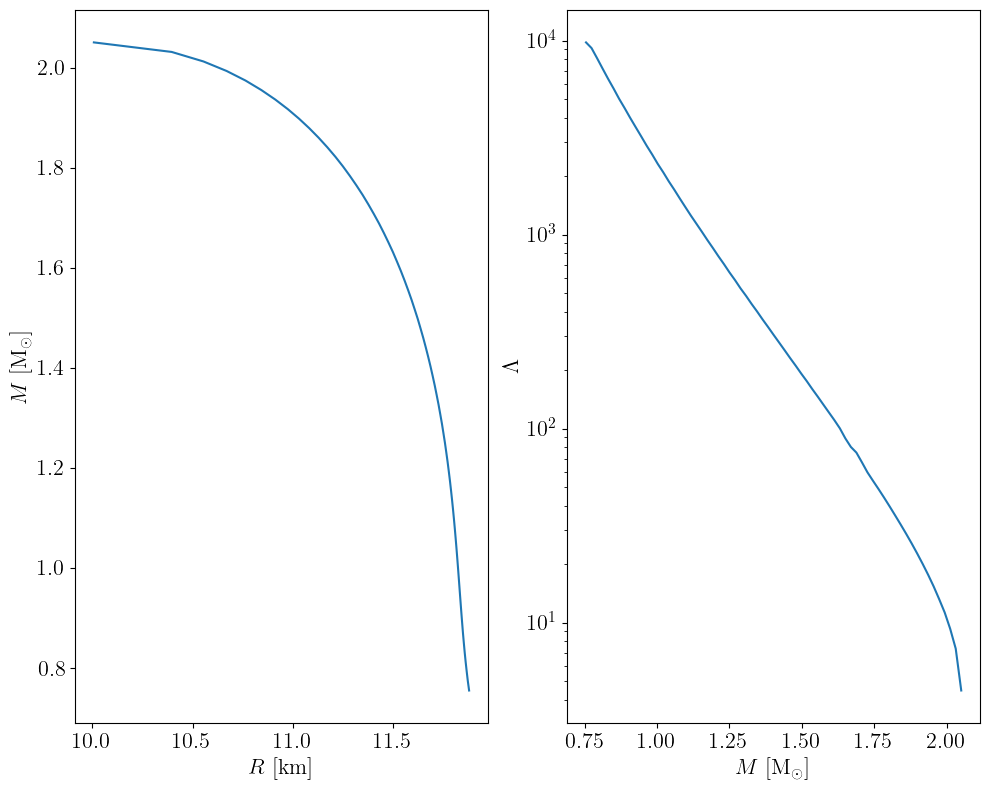

In [6]:
# Solve the TOV equations
out = transform_func(starting_parameters)
m, r, l = out["masses_EOS"], out["radii_EOS"], out["Lambdas_EOS"]

plt.subplots(nrows = 1, ncols = 2, figsize=(10, 8))
mask = m > 0.75
plt.subplot(121)
plt.plot(r[mask], m[mask])
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [M$_\odot$]")

plt.subplot(122)
plt.plot(m[mask], l[mask])
plt.xlabel(r"$M$ [M$_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()

## Score functions

Next, we should define what score or objective function we wish to optimize for. Here, we will use two toy examples:
- A function that returns the maximal allowed mass of a neutron star
- A function that computes the deviation from a given radius at 1.4$M_\odot$. This lies at the basis of the numerical, gradient-based inversion scheme proposed in the `jester` paper.
For each, we allow for a sign parameter to either maximize or minimize the score function.

Note: in order to use `jax.grad` later on, the objective functions must return a scalar value. For vector-valued output, `jax.jacfwd`, `jax.jacrev` should be used. 

In [7]:
def score_fn_mtov(params: dict[str, float],
                  sign = -1) -> tuple:
    """
    Score function where the score is the TOV mass of the EOS corresponding to params.
    The sign is used to indicate whether we want to maximize or minimize the score.
    
    Note that we return the output of the TOV solver in the second argument, which JAX will consider as "aux" in `jax.grad`
    """
    
    out = transform_func(params)
    mtov = jnp.max(out["masses_EOS"])
    score = sign * mtov
    return score, out

def score_fn_radius(params: dict[str, float],
                    sign = +1,
                    target_radius: float = 12.0) -> tuple:
    """
    Score function where the score is the Lambda value at 1.4 Msun of the EOS corresponding to params.
    The sign is used to indicate whether we want to maximize or minimize the score.
    
    Note that we return the output of the TOV solver in the second argument, which JAX will consider as "aux" in `jax.grad`
    """
    
    out = transform_func(params)
    m, r = out["masses_EOS"], out["radii_EOS"]
    R14 = jnp.interp(1.4, m, r)
    score = sign * jnp.abs(R14 - target_radius)
    return score, out

# Optimizer setup

Let us now define the master function that performs several loops of gradient descent with a given learning rate (step size).

Note: to make use of the Adam optimizer, we will use functions from `optax`, which is a library for gradient-based optimization in `JAX`. We also use `tqdm` for a nice progress bar. These are not in the requirements when installing `jester` (since the core functionality does not require it), so you will need to install it separately if you want to run this notebook.

In [8]:
try:
    import optax
    import tqdm
except ImportError:
    raise ImportError("optax and tqdm is not installed. Please install it with 'pip install optax' for this notebook.")

In [9]:
def run(score_fn: Callable,
        starting_parameters: dict[str, float],
        sign: int = -1, 
        nb_steps: int = 200,
        learning_rate: float = 1e-3,):
    
    print("Computing by gradient ascent . . .")
    pbar = tqdm.tqdm(range(nb_steps))
    
    # Define the score function with gradient applied to it. We only differentiate with respect to the first argument.
    score_fn_with_sign = lambda params: score_fn(params, sign)
    score_fn_with_grad = jax.jit(jax.value_and_grad(score_fn_with_sign, argnums=0, has_aux=True))
    
    # Will store the results per iteration in a dict
    trajectory = {}
    params = starting_parameters.copy()
    
    # Initialize the optimizer
    gradient_transform = optax.adam(learning_rate=learning_rate)
    opt_state = gradient_transform.init(params)
    
    for i in pbar:
        ((score, aux), grad) = score_fn_with_grad(params)
        m, r, l = aux["masses_EOS"], aux["radii_EOS"], aux["Lambdas_EOS"]
        
        # Check for NaNs
        if np.any(np.isnan(m)) or np.any(np.isnan(r)) or np.any(np.isnan(l)):
            print(f"Iteration {i} has NaNs. Exiting the computing loop now")
            break
        
        pbar.set_description(f"Iteration {i}: score {score}")
            
        # Apply the gradient updates to the parameters
        updates, opt_state = gradient_transform.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        
        # Enforce no CSE value is above 1 (if needed)
       #for key in params.keys():
          # if "cs2_CSE" in key:
               #params[key] = jnp.clip(params[key], 0, 1)
                
        # Store the results:
        trajectory[i] = {"params": params,
                         "score": score,
                         "masses_EOS": aux["masses_EOS"],
                         "radii_EOS": aux["radii_EOS"],
                         "Lambdas_EOS": aux["Lambdas_EOS"]}
        
    return trajectory

## Runs

Here is a simple plotting script to plot the different iteration results that we can reuse later on

In [10]:
def plot_trajectory(trajectory: dict,
                    plot_score: bool = False):
    """
    Plot the trajectory of the optimization process.
    """
    max_iteration = max(trajectory.keys())
    
    if plot_score:
        plt.figure(figsize=(10, 8))
        plt.plot([trajectory[i]["score"] for i in trajectory.keys()])
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.title("Trajectory of the optimization process")
        plt.show()
        plt.close()
        
    # Prepare color map based on iteration number
    iterations = list(trajectory.keys())
    norm = colors.Normalize(vmin=min(iterations), vmax=max(iterations))
    cmap = cm.viridis
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
        
    # Plot the masses and radii
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 8))
    for i in trajectory.keys():
        color = cmap(norm(i))

        # M(R)
        plt.subplot(121)
        mask = trajectory[i]["masses_EOS"] > 0.75
        plt.plot(trajectory[i]["radii_EOS"][mask], trajectory[i]["masses_EOS"][mask], color=color)
        
        # Lambda(M)
        plt.subplot(122)
        plt.plot(trajectory[i]["masses_EOS"][mask], trajectory[i]["Lambdas_EOS"][mask], color=color)
      
    plt.subplot(121)
    plt.xlabel(r"$R$ [km]")
    plt.ylabel(r"$M$ [M$_\odot$]")
    
    plt.subplot(122)
    plt.xlabel(r"$M$ [M$_\odot$]")
    plt.ylabel(r"$\Lambda$")
    plt.yscale("log")
    plt.tight_layout()
    
    fig.colorbar(sm, ax=axes.ravel().tolist(), label="Iteration")

Let us now do some runs.
On a CPU (Macbook), the speed seems to be around 5 iterations per second.
Note that the first iteration is slower, since `JAX` has to compile the code.

### Maximizing TOV mass

Computing by gradient ascent . . .


Iteration 0: score -2.050259132497719:   1%|          | 1/100 [00:11<18:58, 11.50s/it]

Iteration 1 has NaNs. Exiting the computing loop now


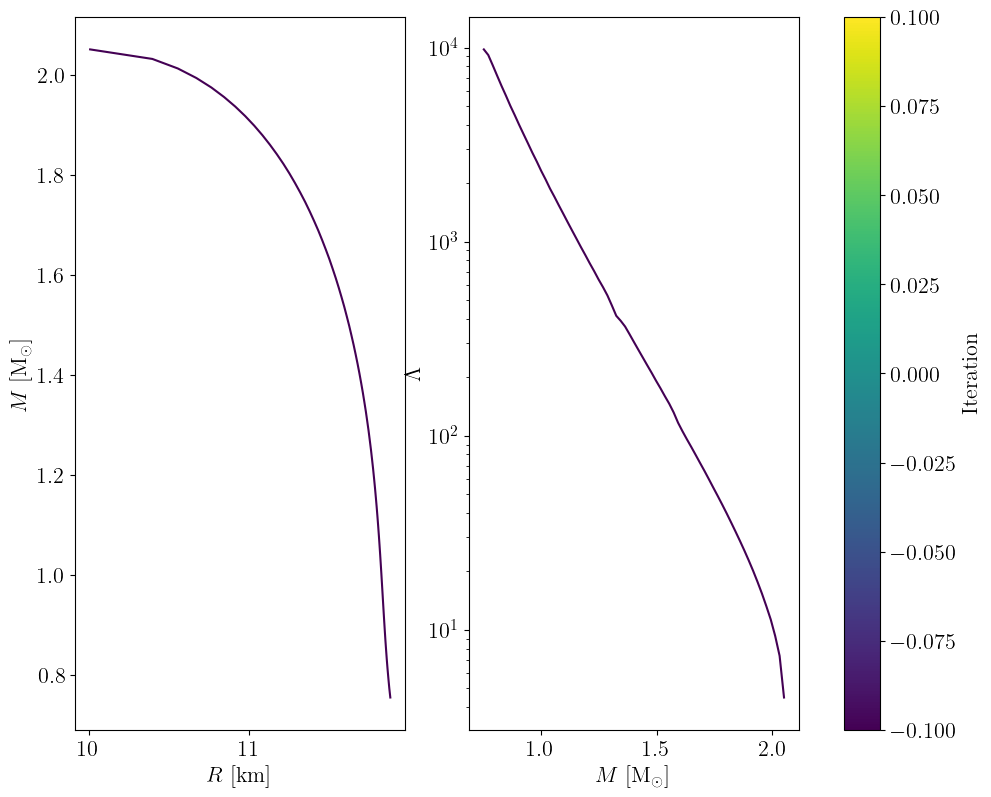

In [12]:

trajectory = run(score_fn_mtov,
                 starting_parameters,
                 sign = -1,
                 nb_steps = 100,
                 learning_rate = 1e-3)
plot_trajectory(trajectory)
plt.show()
plt.close()

### Towards target radius at 1.4 solar mass

Computing by gradient ascent . . .


Iteration 0: score 0.3137418315724414:   1%|          | 1/150 [00:11<27:42, 11.16s/it]

Iteration 1 has NaNs. Exiting the computing loop now


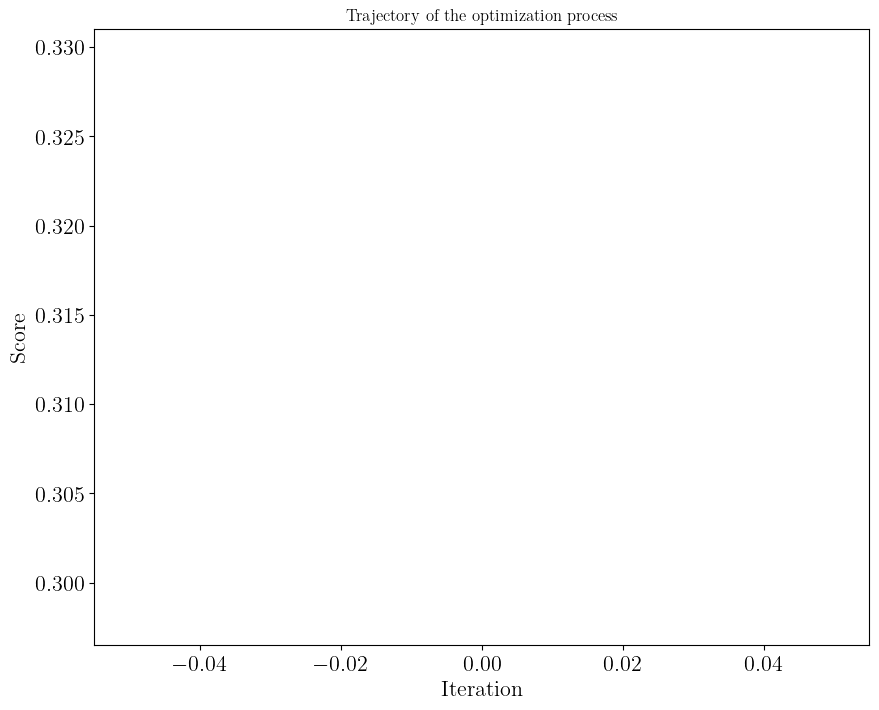

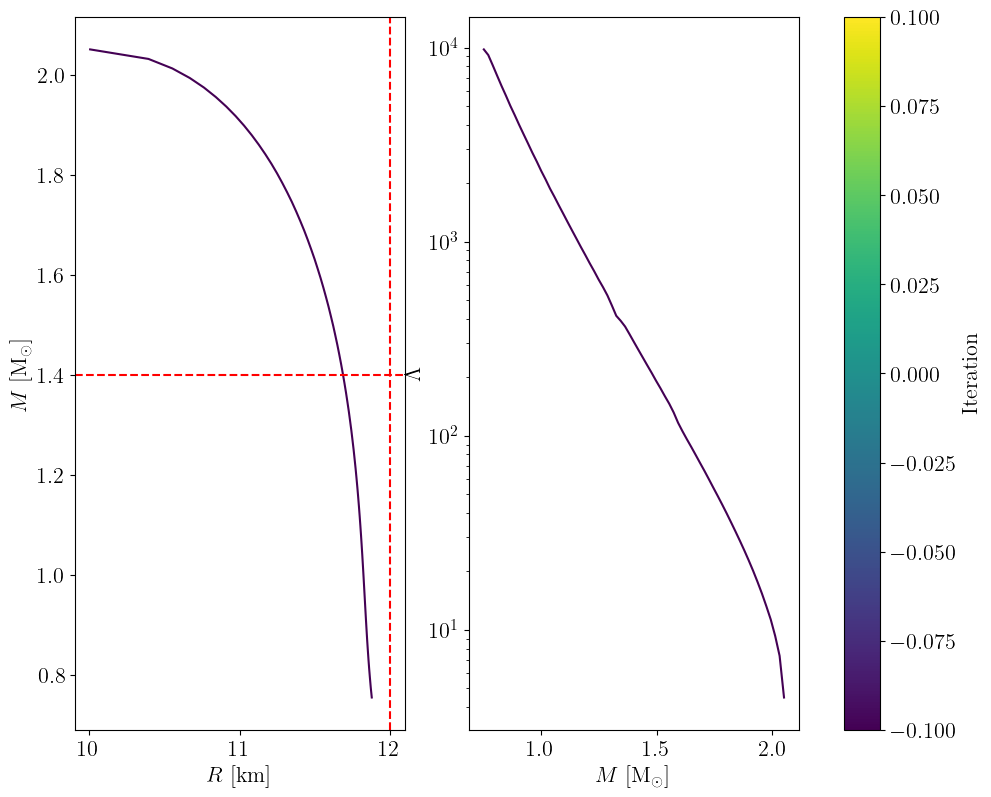

In [13]:
trajectory = run(score_fn_radius,
                 starting_parameters,
                 sign = +1,
                 nb_steps = 150,
                 learning_rate = 1e-3)
plot_trajectory(trajectory, plot_score = True) # plot_score: to show convergence
plt.subplot(121)
plt.axhline(y=1.4, color='r', linestyle='--')
plt.axvline(x=12.0, color='r', linestyle='--')
plt.show()
plt.close()

### Parameter trajectory

For this final example, let us show the trajectory of the parameters during the optimization process to show that all of them evolve somewhat independently (although some are more correlated than others).

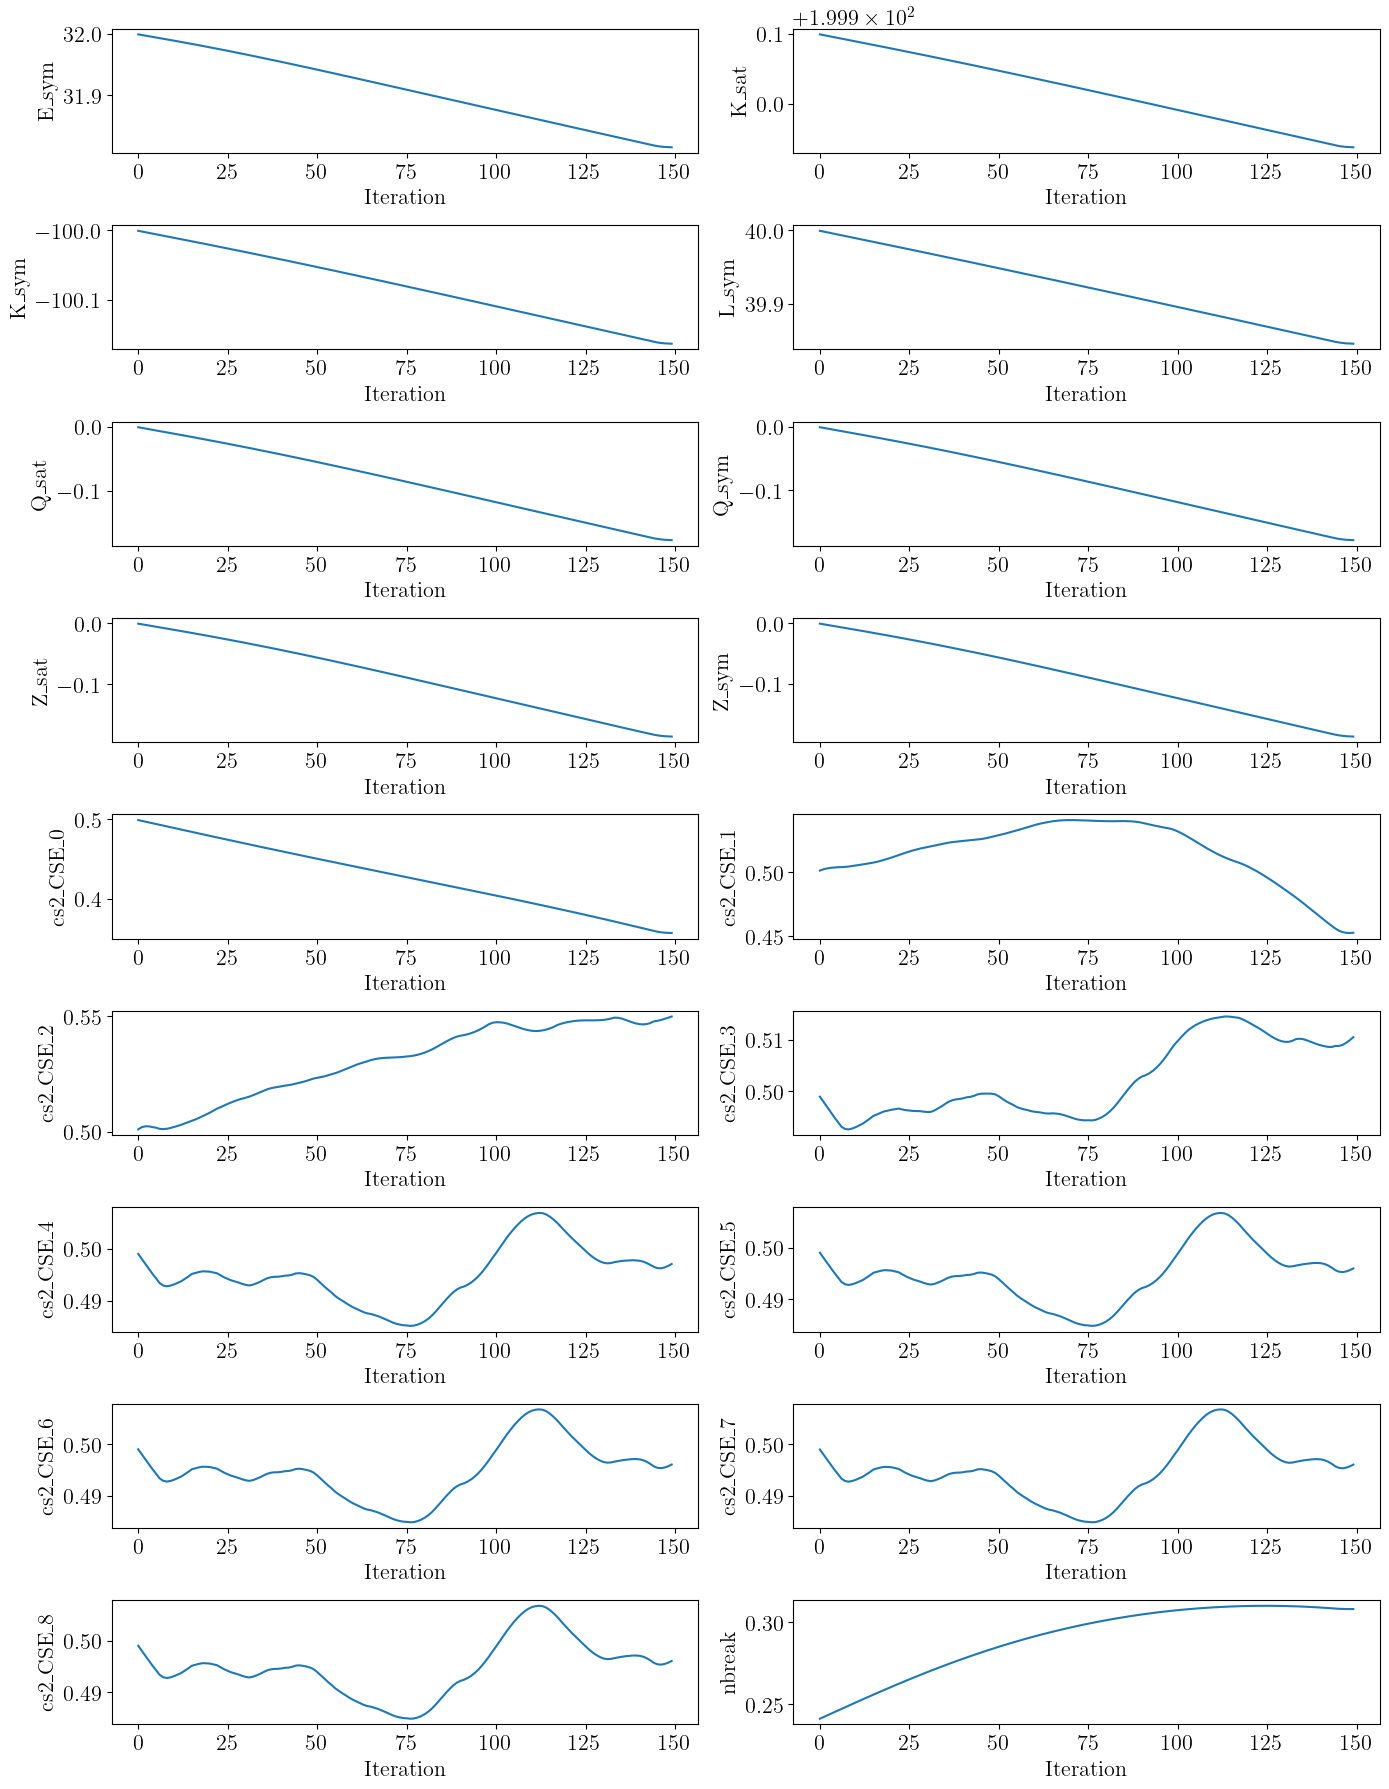

In [14]:
# Get names of parameters that are not fixed
param_names = [name for name in trajectory[0]["params"].keys()
                if name not in fixed_params.keys()]

n_params = len(param_names)
n_rows, n_cols = 9, 2 # watch out: this is for the specific case of fixed parameters considered here by default!

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 18))
axes = axes.flatten()

for idx, name in enumerate(param_names):
    ax = axes[idx]
    ax.plot([trajectory[i]["params"][name] for i in trajectory.keys()])
    ax.set_xlabel("Iteration")
    ax.set_ylabel(name)

# Hide any unused subplots (if fewer than 18)
for j in range(len(param_names), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.close()

# Closing remarks

Here, we have focused on an 18-dimensional parameter space for simplicity, but we could easily extend this to the full `jester` model defined above. The runtime is basically the same -- this is the power of JAX!

starting_parameters are: 27 in total
{'K_sat': 200.0, 'Q_sat': 0.0, 'Z_sat': 0.0, 'E_sym': 32.0, 'L_sym': 40.0, 'K_sym': -100.0, 'Q_sym': 0.0, 'Z_sym': 0.0, 'nbreak': 0.24, 'cs2_CSE_0': 0.5, 'cs2_CSE_1': 0.5, 'cs2_CSE_2': 0.5, 'cs2_CSE_3': 0.5, 'cs2_CSE_4': 0.5, 'cs2_CSE_5': 0.5, 'cs2_CSE_6': 0.5, 'cs2_CSE_7': 0.5, 'cs2_CSE_8': 0.5, 'E_sat': -16.0, 'n_CSE_0': 0.48, 'n_CSE_1': 0.64, 'n_CSE_2': 0.8, 'n_CSE_3': 0.96, 'n_CSE_4': 1.12, 'n_CSE_5': 1.28, 'n_CSE_6': 1.44, 'n_CSE_7': 1.6}
Computing by gradient ascent . . .


Iteration 74: score 0.011994158359247109: 100%|██████████| 75/75 [00:23<00:00,  3.13it/s] 


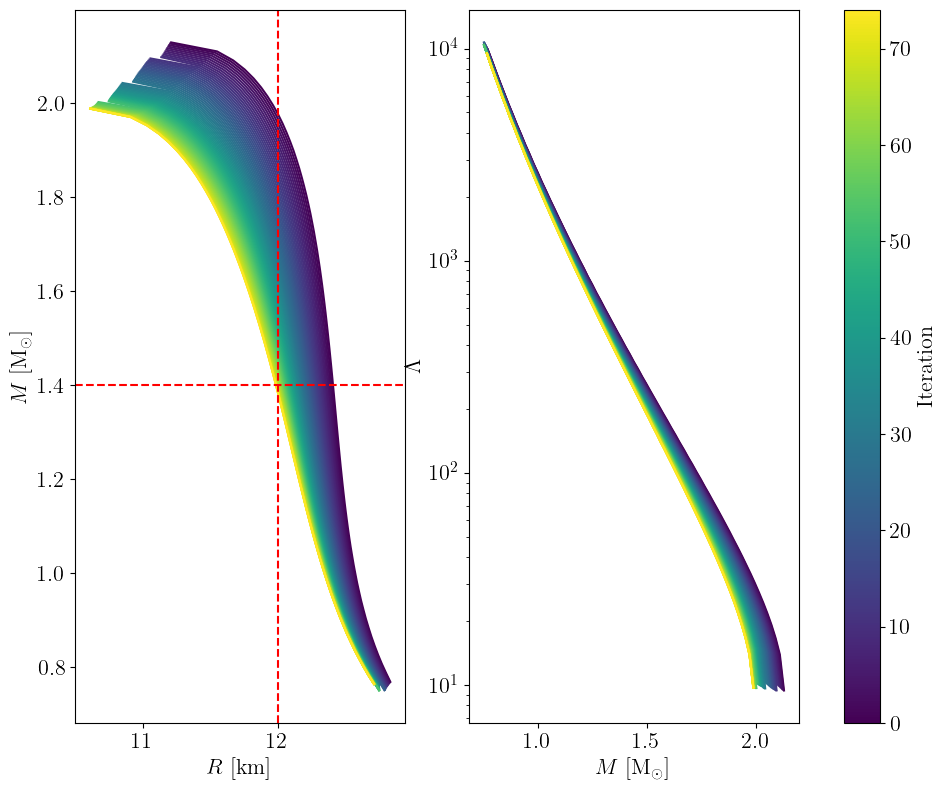

In [18]:
starting_parameters.update(fixed_params)

print(f"starting_parameters are: ({len(starting_parameters)} in total)")
print(starting_parameters)

trajectory = run(score_fn_radius,
                 starting_parameters,
                 {},
                 sign = +1,
                 nb_steps = 75, # lower number of iterations are needed, we converge faster!
                 learning_rate = 1e-3)
plot_trajectory(trajectory)
plt.subplot(121)
plt.axhline(y=1.4, color='r', linestyle='--')
plt.axvline(x=12.0, color='r', linestyle='--')
plt.show()
plt.close()

Parameter trajectory (not shown: many plots!)

In [16]:
# for name in trajectory[0]["params"].keys():
#     if name not in fixed_params.keys():
#         # Make a plot
#         plt.figure(figsize=(6, 4))
#         plt.plot([trajectory[i]["params"][name] for i in trajectory.keys()])
#         plt.xlabel("Iteration")
#         plt.ylabel(name)
#         plt.show()
#         plt.close()